### Import the libraries and data

In [394]:
import pandas as pd
import numpy as np
import scipy.stats as stat
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.tree import plot_tree

lower_bound = 2011
team_colours = {"Ireland": "limegreen", 'New Zealand': "black", 'South Africa': "darkgreen", \
                "Argentina": "royalblue", 'France': 'blue', 'Italy': 'skyblue', \
                "England": "grey", "Scotland": "purple", 'Wales': 'red', 'Australia': 'orange'}
team_list = list(team_colours.keys())
team_list.sort()
team = "Ireland"

team_map = {}
for i in range(len(team_list)):
    team_map[team_list[i]] = i+1

data = pd.read_csv('results.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,False
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,False
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,False
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,False
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,False


### Pre-process the data starting from lower_bound onwards. 
- I want to consider the last x years and look to predict the 2024 Six Nations results

In [395]:
# df = data[(data['neutral'] == False) & (data['world_cup'] == False)  & (data['date'].dt.year >= lower_bound)]\
#         .drop(columns=['competition', 'stadium', 'city', 'country', 'neutral', 'world_cup'])
df = data.copy()
df['score_diff'] = df['home_score']-df['away_score']
df['home_win'] = df.apply(lambda x: 1 if x['neutral'] == 0 and x['home_score'] > x['away_score'] else 0, axis = 1)
df['away_win'] = df.apply(lambda x: 1 if x['neutral'] == 0 and x['home_score'] < x['away_score'] else 0, axis = 1)
df['draw'] = df.apply(lambda x: 1 if x['score_diff'] == 0 else 0, axis = 1)

df['neutral'] = df.apply(lambda x: 1 if x['neutral'] == True else 0, axis = 1)
df['world_cup'] = df.apply(lambda x: 1 if x['world_cup'] == True else 0, axis = 1)
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].dt.year >= lower_bound].drop(columns=['competition', 'stadium', 'city', 'country'])
df = df.reset_index(drop=True)
df

,date,home_team,away_team,home_score,away_score,neutral,world_cup,score_diff,home_win,away_win,draw
0,2011-02-04,Wales,England,19,26,0,0,-7,0,1,0
1,2011-02-05,France,Scotland,34,21,0,0,13,1,0,0
2,2011-02-05,Italy,Ireland,11,13,0,0,-2,0,1,0
3,2011-02-12,England,Italy,59,13,0,0,46,1,0,0
4,2011-02-12,Scotland,Wales,6,24,0,0,-18,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
625,2023-09-08,France,New Zealand,27,13,0,1,14,1,0,0
626,2023-09-09,England,Argentina,27,10,1,1,17,0,0,0
627,2023-09-10,South Africa,Scotland,18,3,1,1,15,0,0,0
628,2023-09-23,South Africa,Ireland,8,13,1,1,-5,0,0,0


### The plot of how the score_diff changes over time and for each team
- We see that other than the initial portion, the cumulative score difference tends to remain highly positive indicating that there is some benefit to being the home team
- For the northern teams, Italy is the only one on a consistent decline, and for southern teams it is Argentina

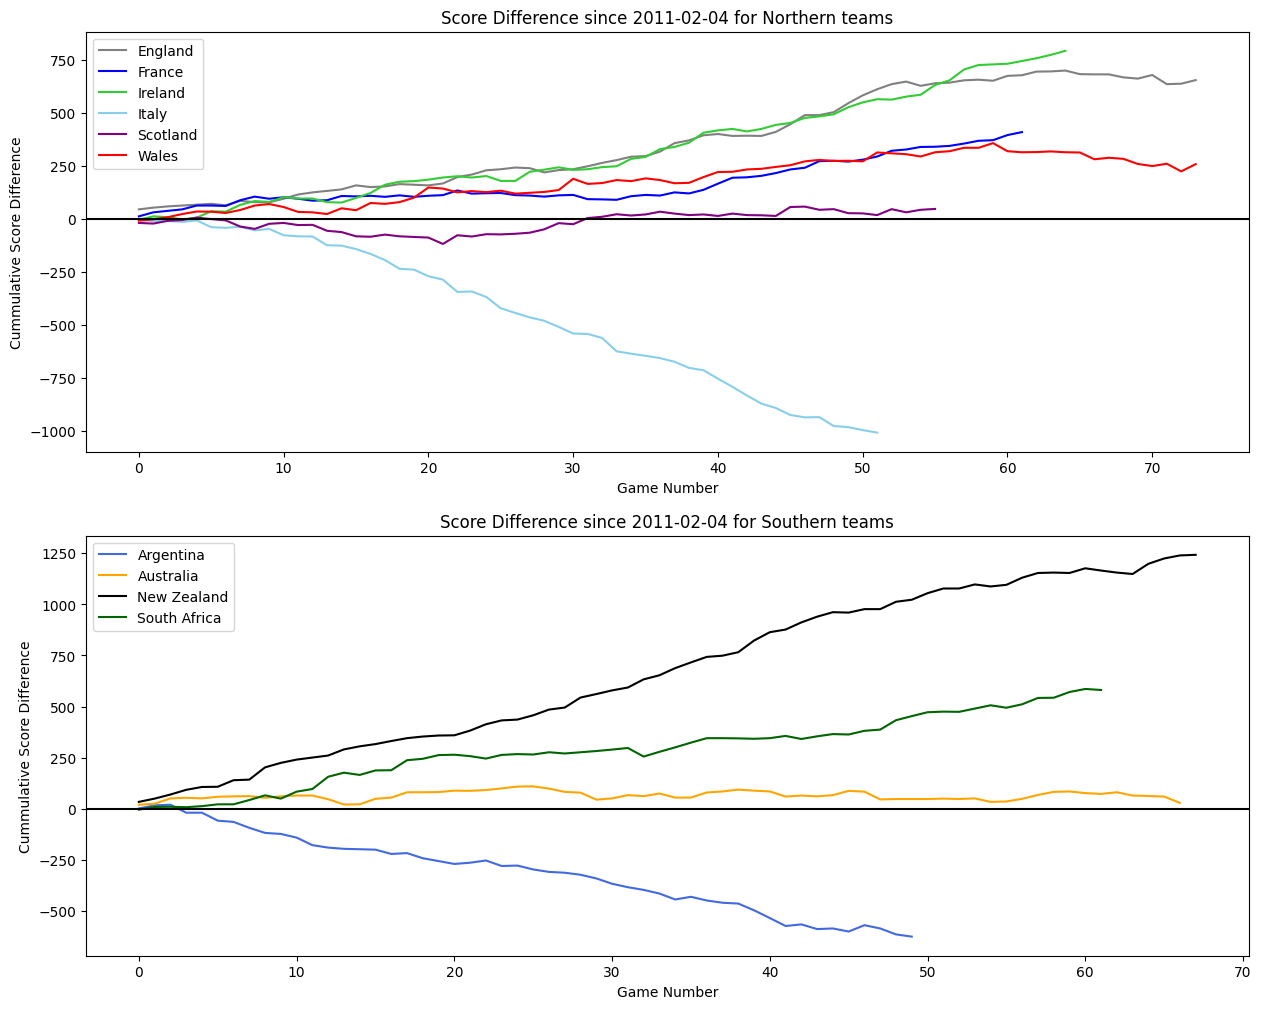

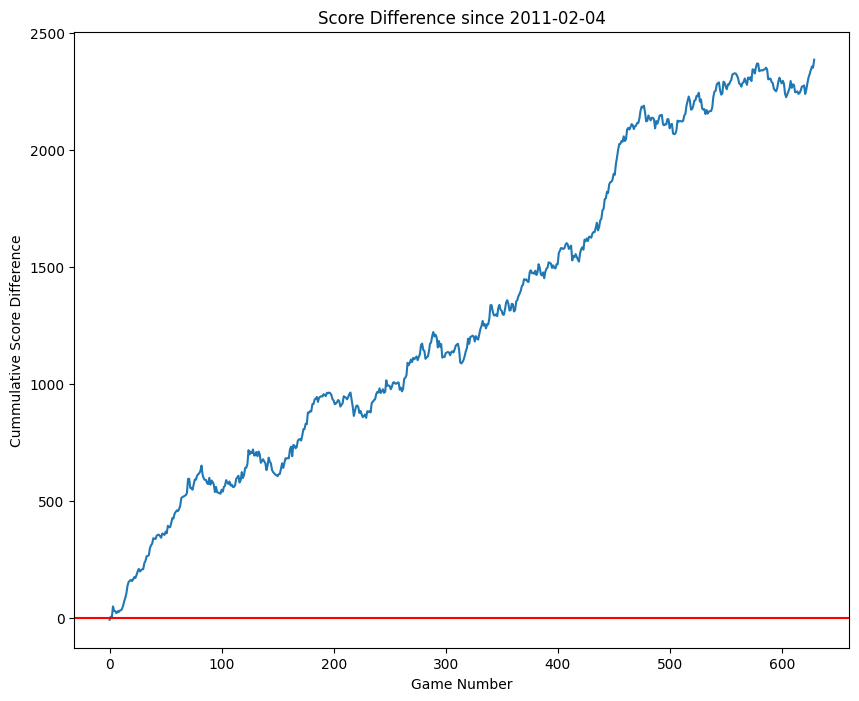

In [396]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 12))
nh = ['Ireland', 'England', 'Scotland', 'Italy', 'France', 'Wales']
nh.sort()

for home_team, data in df.groupby('home_team'):
    subset = data.reset_index(drop = True)
    if home_team in nh:
        axs[0].plot(subset.index, np.cumsum(subset['score_diff']), label=str(home_team), color = team_colours[home_team])
    else:
        axs[1].plot(subset.index, np.cumsum(subset['score_diff']), label=str(home_team), color = team_colours[home_team])

axs[0].set_xlabel('Game Number')
axs[0].set_ylabel('Cummulative Score Difference')
axs[0].set_title('Score Difference since ' + df['date'].dt.strftime("%Y-%m-%d")[0] + " for Northern teams")
axs[0].legend()
axs[0].axhline(y = 0, color = 'black', linestyle = '-')

axs[1].set_xlabel('Game Number')
axs[1].set_ylabel('Cummulative Score Difference')
axs[1].set_title('Score Difference since ' + df['date'].dt.strftime("%Y-%m-%d")[0] + " for Southern teams")
axs[1].legend()
axs[1].axhline(y = 0, color = 'black', linestyle = '-')

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 8))
plt.plot(np.cumsum(df['score_diff']))
plt.xlabel('Game Number')
plt.ylabel('Cummulative Score Difference')
plt.title('Score Difference since ' + df['date'].dt.strftime("%Y-%m-%d")[0])
plt.axhline(y = 0, color = 'r', linestyle = '-')

plt.show()

### We begin our modelling process
- My goal is to use a Random Forest model, with the games from lower_bound onwards to predict the score difference for the team in the 2024 Six Nations results
- We create the df here

In [397]:
six_nations_teams = nh
opposition_map = {}

for key, value in team_map.items():
    if key != team:
        opposition_map[key] = value

## Form the df for the team we are focusing on 
team_df = df[(df['home_team'] == team) | (df['away_team'] == team)].reset_index(drop = True)
team_df["home"] = team_df.apply(lambda x: 1 if x['home_team'] == team else 0, axis = 1)
team_df["away"] = abs(1-team_df["home"])

team_df['score_diff'] = team_df.apply(lambda x: x['home_score'] - x['away_score'] if x['home_team'] == team else -x['home_score'] + x['away_score'], axis = 1)
team_df['home_win'] = team_df.apply(lambda x: 1 if x['home'] == 1 and x['score_diff'] > 0 else 0, axis = 1)
team_df['away_win'] = team_df.apply(lambda x: 1 if x['away'] == 1 and x['score_diff'] > 0 else 0, axis = 1)
team_df['opposition'] = team_df.apply(lambda x: x['away_team'] if x['home_team'] ==  team else x['home_team'], axis = 1)
team_df['opposition'] = team_df.apply(lambda x: opposition_map[x['opposition']], axis = 1)

### We do some correlation analysis to determine the best set of variables, and also whether we need to create lagged variables

score_diff
   Lag  CCF
0    0  1.0


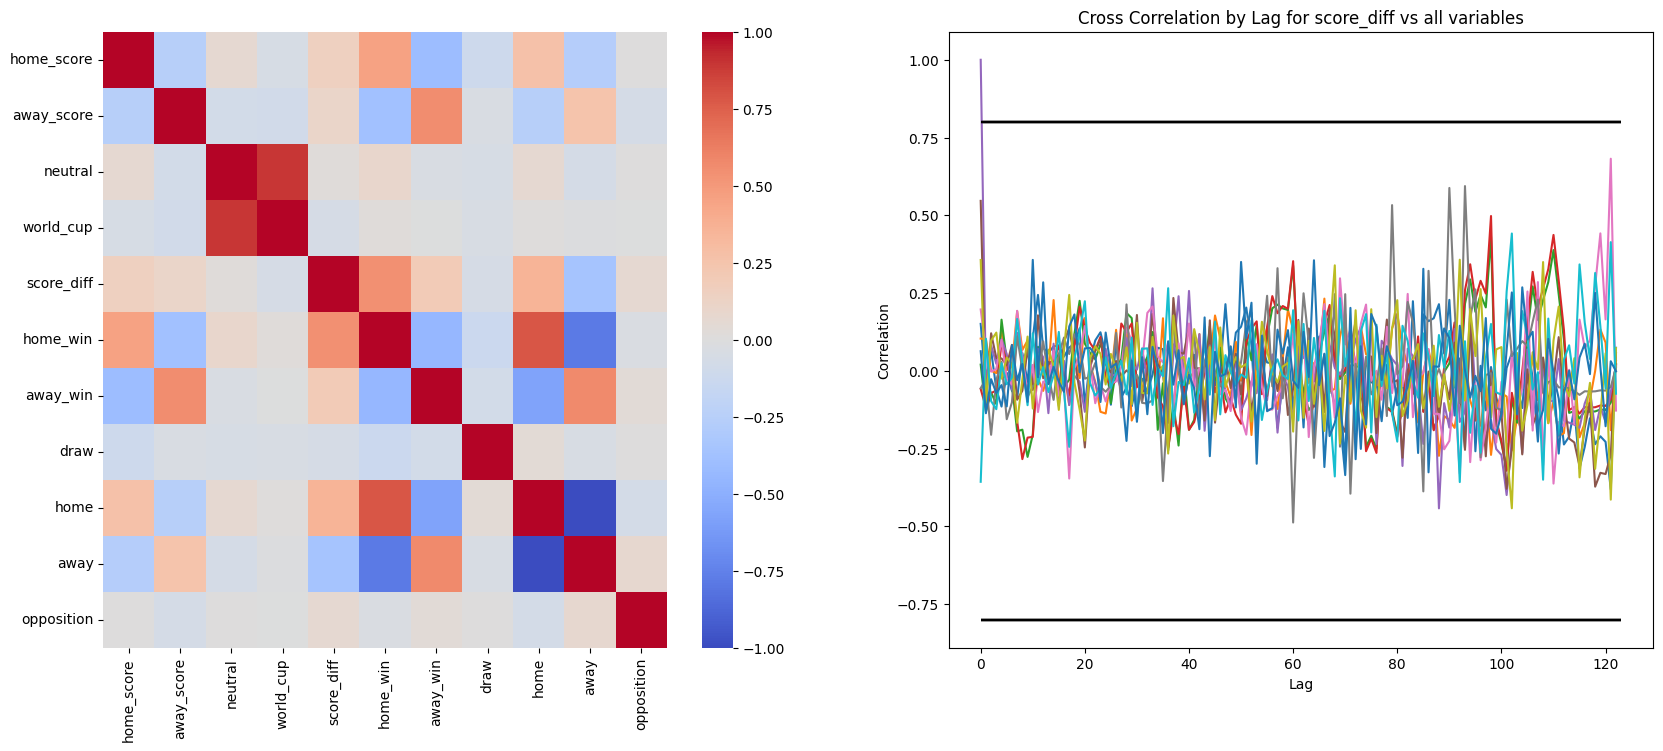

In [398]:
corr_df = team_df.copy()
corr_df = corr_df.drop(columns=['date', 'home_team', 'away_team'])
correlation_matrix = corr_df.corr()

fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))

sns.heatmap(correlation_matrix, ax = axes[0], cmap = 'coolwarm')

for var in corr_df.columns:
    ccf_val = ccf(corr_df['score_diff'], corr_df[var])
    ccf_df = pd.DataFrame({'Lag': [i for i in range(len(ccf_val))], "CCF": ccf_val})

    ccf_df = ccf_df[abs(ccf_df['CCF']) <= 1]
    axes[1].plot(ccf_val)
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("Correlation")
    axes[1].set_title(f"Cross Correlation by Lag for score_diff vs all variables")
    axes[1].hlines(y = 0.8, xmin = 0, xmax = len(ccf_val), color = 'black')
    axes[1].hlines(y = -0.8, xmin = 0, xmax = len(ccf_val), color = 'black')

    sig_lag = ccf_df[abs(ccf_df['CCF']) >= 0.8]

    if len(sig_lag) > 0:
        print(var, sig_lag, sep = '\n')

plt.show()

### We create our lagged variables

In [399]:
## Create previous game encounter
previous_df = team_df.copy()
previous_df['date'] = pd.to_datetime(previous_df['date'])
previous_df['prev date'] = pd.to_datetime(previous_df.groupby('opposition')['date'].shift())
previous_df['diff'] = (previous_df['date'] - previous_df['prev date']).dt.days
previous_df['weight'] =  previous_df['diff'] ## This is to make the more recent results add more value to the model

previous_df['prev score_diff'] = previous_df.groupby('opposition')['score_diff'].shift()
previous_df['prev home_win'] = previous_df.groupby('opposition')['home_win'].shift()
previous_df['prev away_win'] = previous_df.groupby('opposition')['away_win'].shift()

previous_df['prev draw'] = previous_df.groupby('opposition')['draw'].shift()
previous_df['prev home'] = previous_df.groupby('opposition')['home'].shift()
previous_df['prev away'] = previous_df.groupby('opposition')['away'].shift()


previous_df['prev neutral'] = previous_df.groupby('opposition')['neutral'].shift()
previous_df['prev world_cup'] = previous_df.groupby('opposition')['world_cup'].shift()

previous_df = previous_df[['date', 'home_team', 'away_team', \
                           'prev score_diff', 'prev home_win', 'prev away_win', \
                           'prev draw', 'prev home', 'prev away', 'prev date', "weight",\
                            "prev neutral", 'prev world_cup']]

## Merge the two df's 
new_team_df = pd.merge(left = team_df, right = previous_df, how = 'right', on = ['date', 'home_team', 'away_team'])
new_team_df['date'] = pd.to_datetime(new_team_df['date'])
new_team_df.dropna(inplace=True)
new_team_df = new_team_df[new_team_df['date'].dt.year >= lower_bound + 1].reset_index(drop = True)
new_team_df.head()

,date,home_team,away_team,home_score,away_score,neutral,world_cup,score_diff,home_win,away_win,...,prev score_diff,prev home_win,prev away_win,prev draw,prev home,prev away,prev date,weight,prev neutral,prev world_cup
0,2012-02-05,Ireland,Wales,21,23,0,0,-2,0,0,...,-12.0,0.0,0.0,0.0,0.0,1.0,2011-10-08,120.0,1.0,1.0
1,2012-02-25,Ireland,Italy,42,10,0,0,32,1,0,...,30.0,1.0,0.0,0.0,1.0,0.0,2011-10-02,146.0,1.0,1.0
2,2012-03-04,France,Ireland,17,17,0,0,0,0,0,...,-4.0,0.0,0.0,0.0,1.0,0.0,2011-08-20,197.0,0.0,0.0
3,2012-03-10,Ireland,Scotland,32,14,0,0,18,1,0,...,-4.0,0.0,0.0,0.0,0.0,1.0,2011-08-06,217.0,0.0,0.0
4,2012-03-17,England,Ireland,30,9,0,0,-21,0,0,...,-11.0,0.0,0.0,0.0,1.0,0.0,2011-08-27,203.0,0.0,0.0


### We move on to the Random Forest model

opposition:  England 
MSE =  88.209 
MAPE =  0.48 
R^2 =  0.478

opposition:  France 
MSE =  248.834 
MAPE =  4.001 
R^2 =  -2.676

opposition:  Italy 
MSE =  447.234 
MAPE =  0.709 
R^2 =  -1.317

opposition:  Scotland 
MSE =  23.52 
MAPE =  0.269 
R^2 =  0.45

opposition:  Wales 
MSE =  143.887 
MAPE =  0.875 
R^2 =  -0.163



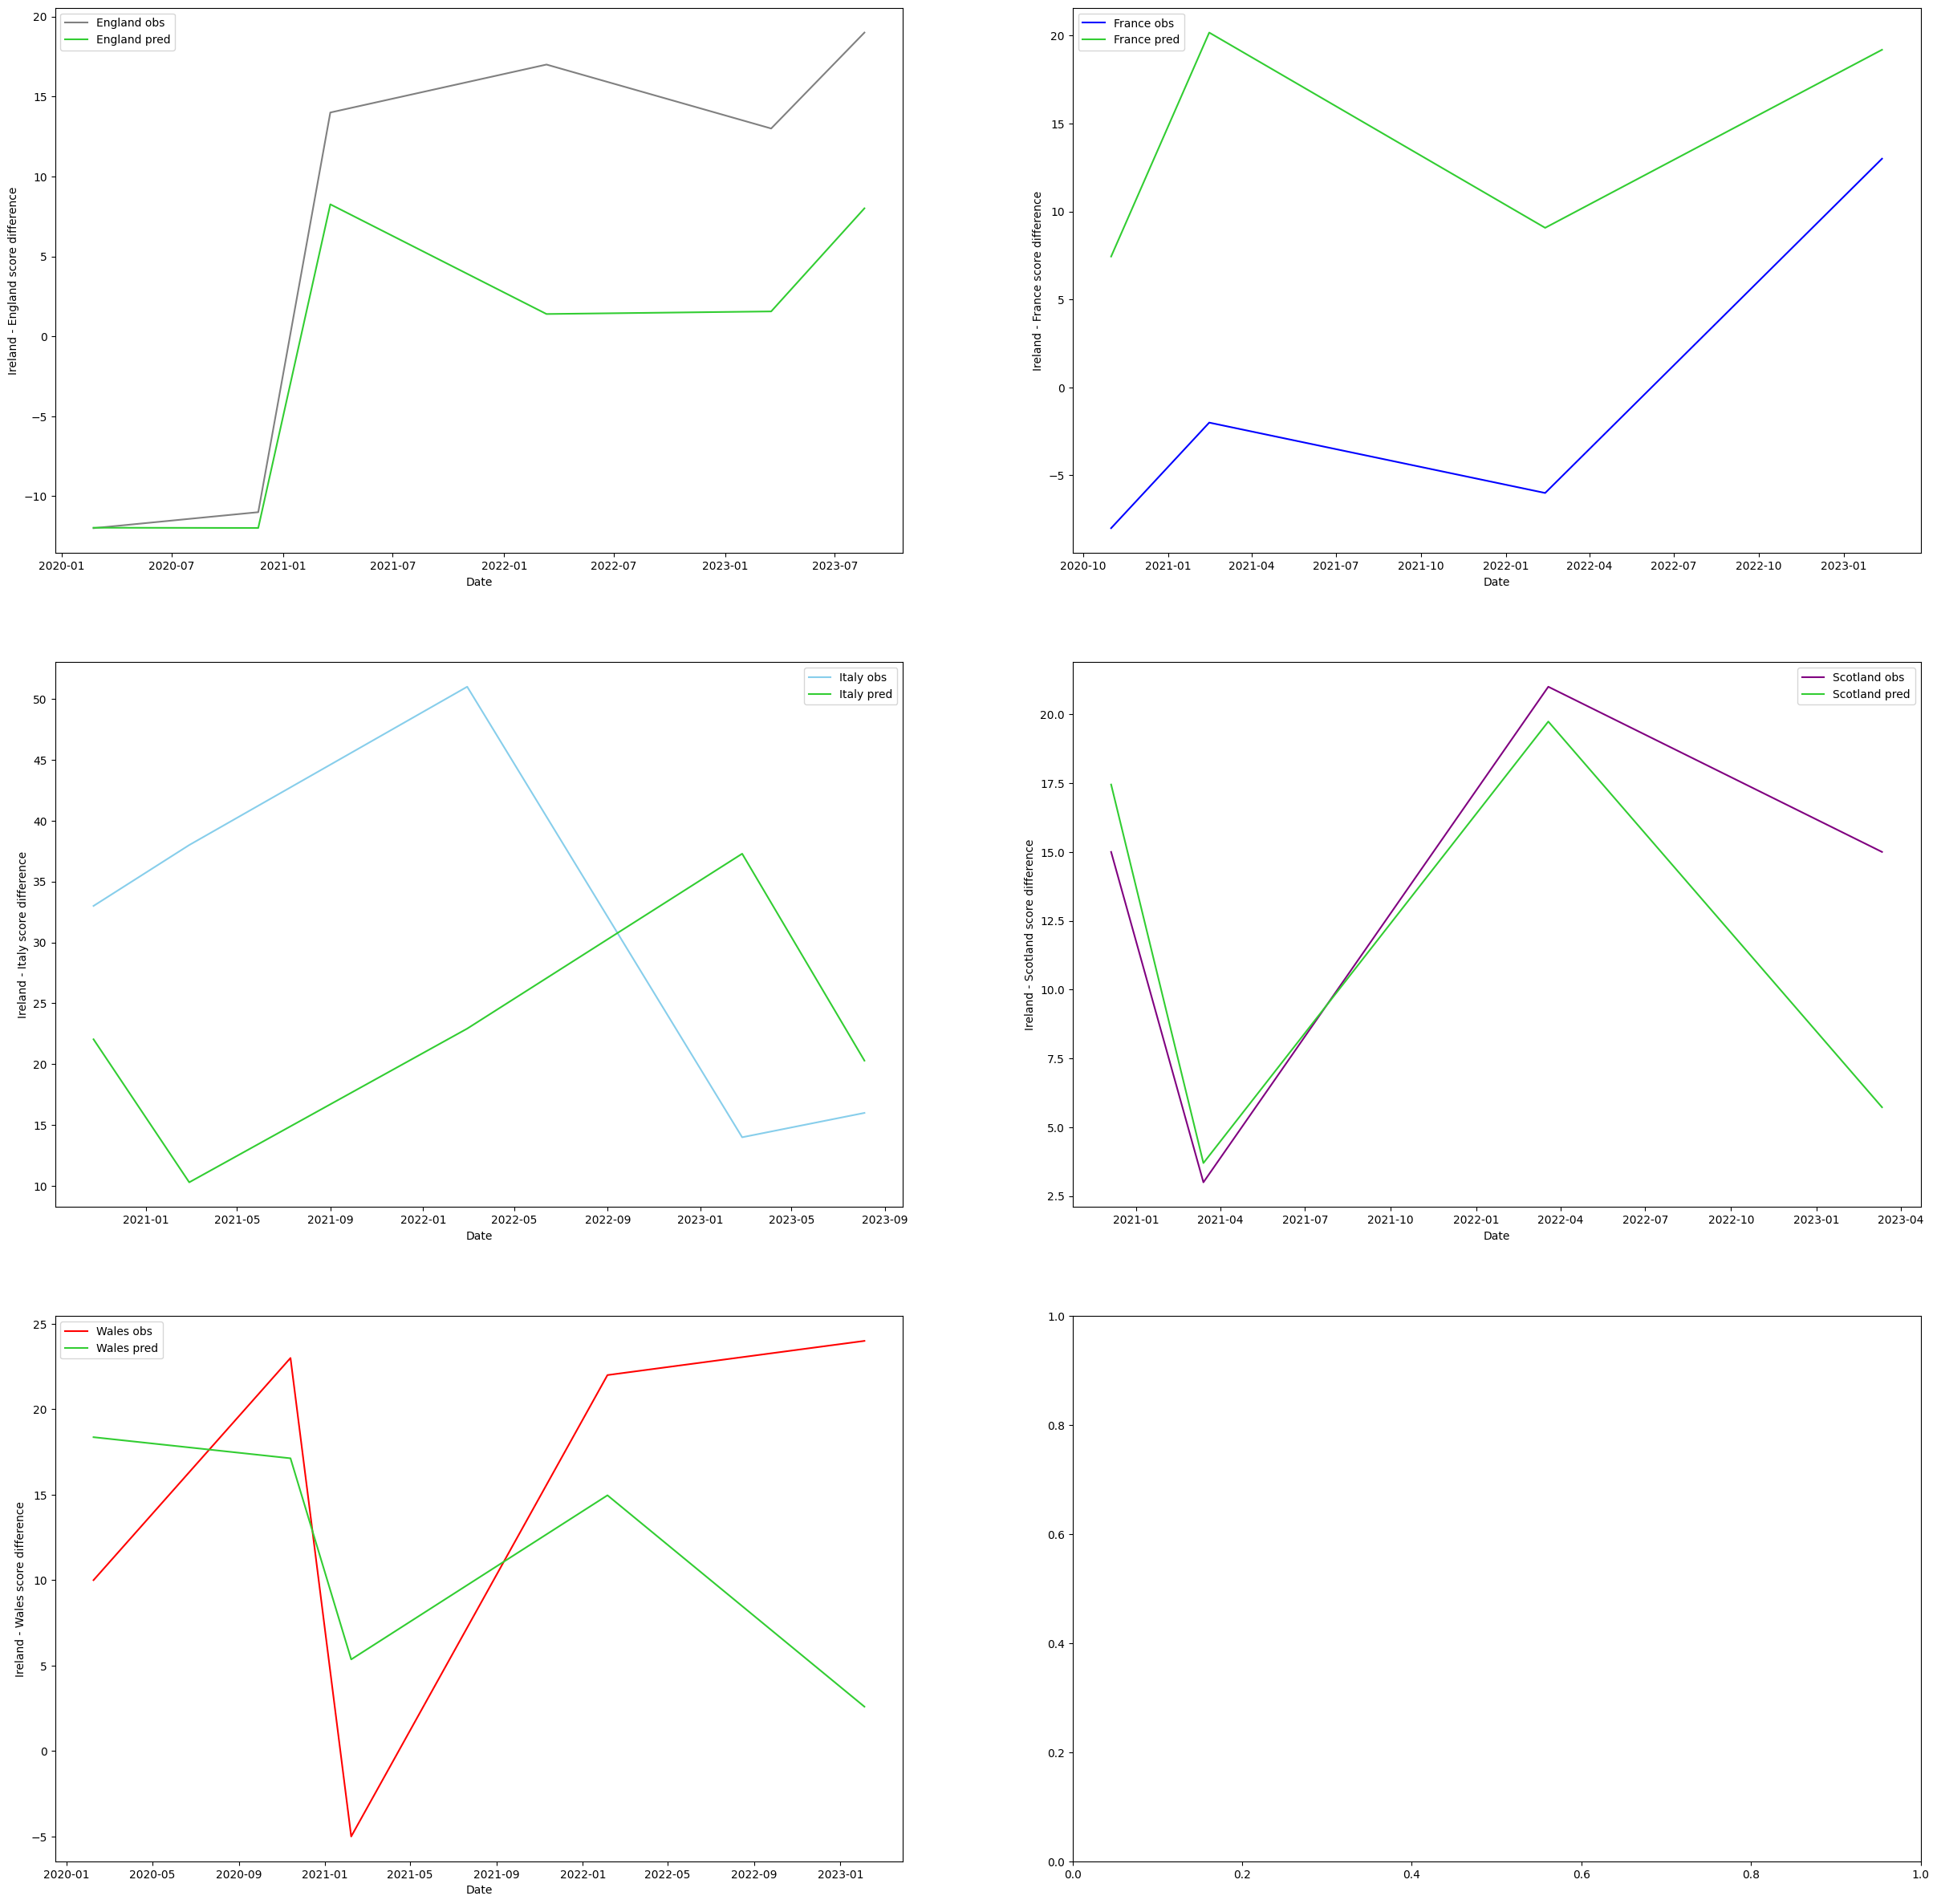

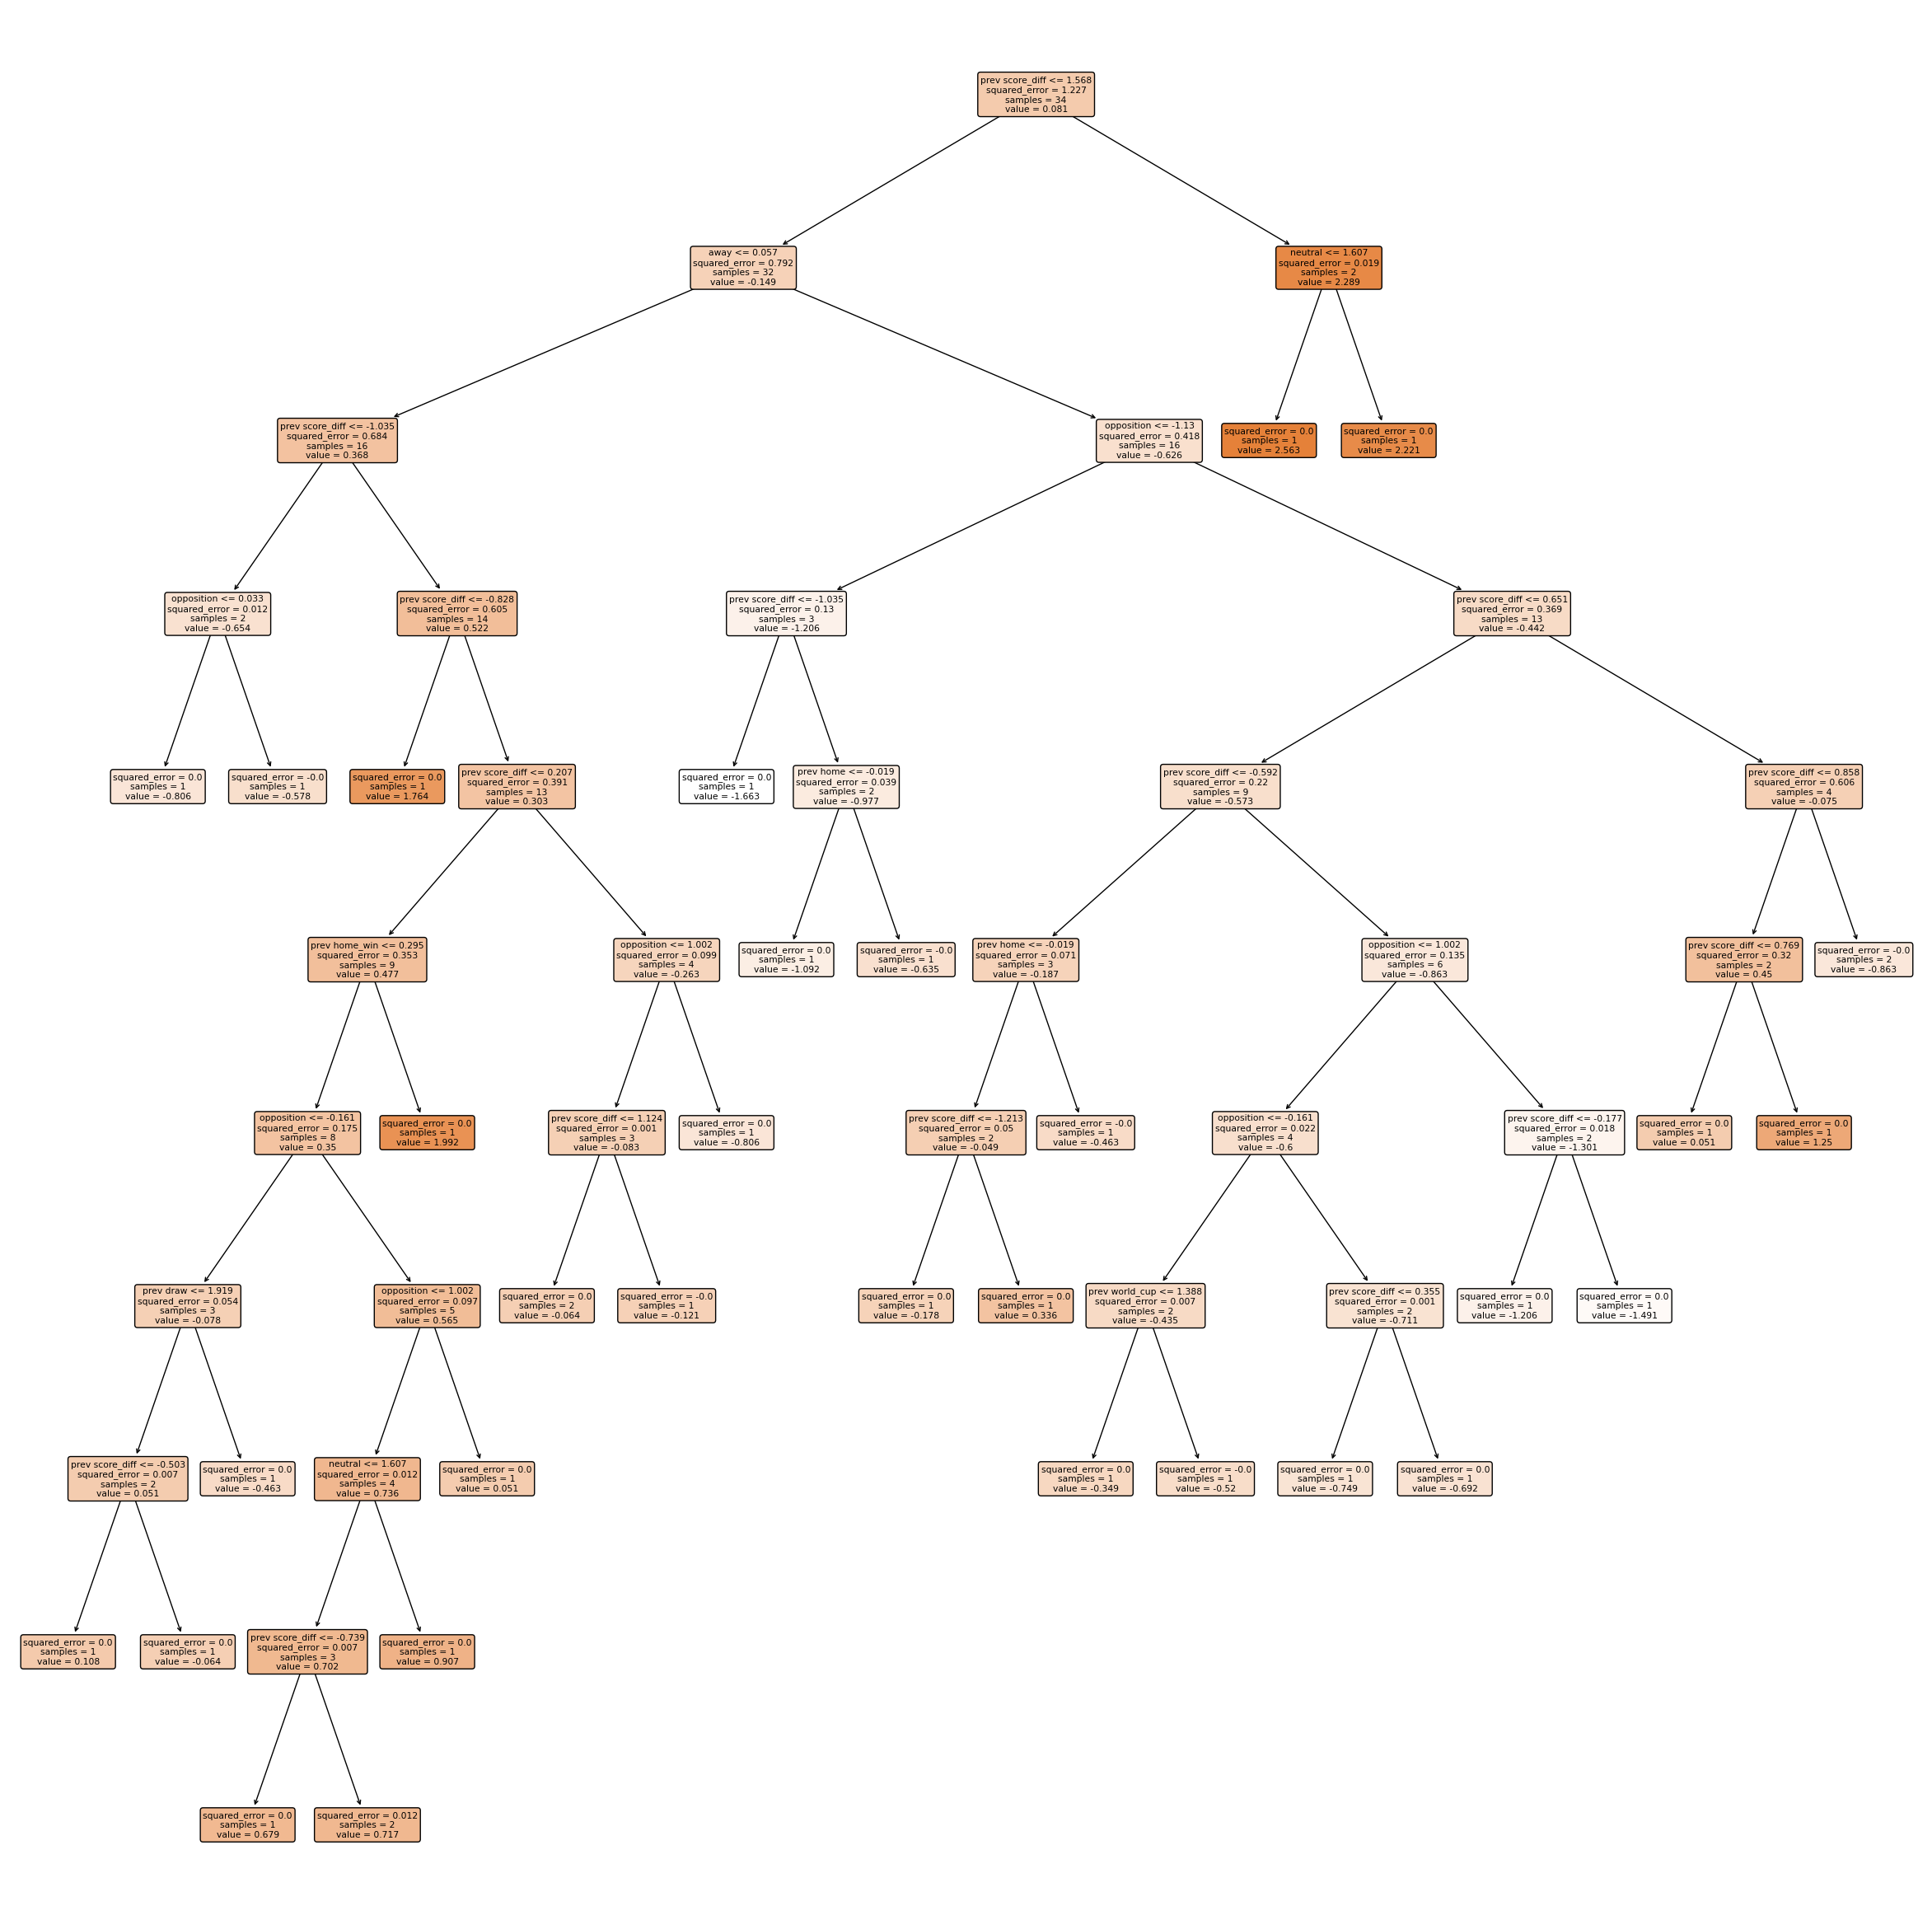

In [400]:
# Split X and Y
selected_params = ['home', 'away', 'neutral', 'world_cup', 'opposition', \
                   'prev score_diff', 'prev home_win', 'prev away_win', 'prev draw', \
                    'prev home', 'prev away', 'prev neutral', 'prev world_cup']

model_df = new_team_df.copy()
model_df = model_df[(model_df['home_team'].isin(six_nations_teams)) & (model_df['away_team'].isin(six_nations_teams))].reset_index(drop = True)

matchup = model_df[['date', 'home_team', 'away_team']]
X = model_df[selected_params]
y = model_df['score_diff']

## Create training and testing
split_loc = int(0.7*len(model_df))
X_train, X_test = X[0:split_loc], X[split_loc:].reset_index(drop = True)
y_train, y_test = y[0:split_loc], y[split_loc:].reset_index(drop = True)
matchup_test = matchup[split_loc:].reset_index(drop = True)
observed = y_test

## Reshape and scale 
scaler = StandardScaler()
X_train = np.array(pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns))
X_test = np.array(pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns))
y_train = np.array(pd.DataFrame(scaler.fit_transform(np.array([y_train]).reshape(-1, 1))))
y_test = np.array(pd.DataFrame(scaler.fit_transform(np.array([y_test]).reshape(-1, 1))))

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

## Create random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (30, 30))

## Create prediction dataframe with only Six Nations teams
prediction_df = pd.DataFrame({"Observed": np.array(observed), "Predicted": scaler.inverse_transform(pred.reshape(-1, 1)).flatten()})
prediction_df = pd.concat([matchup_test, prediction_df], axis = 1)
prediction_df['opposition'] = prediction_df.apply(lambda x: x['away_team'] if x['home_team'] ==  team else x['home_team'], axis = 1)
prediction_df = prediction_df[prediction_df['opposition'].isin(six_nations_teams)]

i = 0
for opposition, data in prediction_df.groupby('opposition'):
    subset = data.reset_index(drop = True)

    ## Metrics
    mse = mean_squared_error(subset['Observed'], subset['Predicted'])
    mape = mean_absolute_percentage_error(subset['Observed'], subset['Predicted'])
    r2 = r2_score(subset['Observed'], subset['Predicted'])
    print("opposition: ", opposition, "\nMSE = ", round(mse, 3), "\nMAPE = ", round(mape, 3), "\nR^2 = ", round(r2, 3), end = '\n\n')

    axs[i//2, i % 2].plot(subset['date'], subset['Observed'], label=str(opposition) + " obs", color = team_colours[opposition])
    axs[i//2, i % 2].plot(subset['date'], subset['Predicted'], label=str(opposition) + " pred", color = team_colours[team])
    axs[i//2, i % 2].set_xlabel("Date")
    axs[i//2, i % 2].set_ylabel(f"{team} - {opposition} score difference")
    axs[i//2, i % 2].legend()

    i += 1

plt.show()

## Plot Random Forest
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (30, 30))
estimator = model.estimators_[0]
plot_tree(estimator, feature_names = selected_params, filled=True, rounded=True)
plt.show()